# Tutorial on How to Implement a Jumanji Environment

## What this notebook is

- This notebook is a self-contained minimal implementation of a Jumanji environment. It runs entirely in about 20 seconds only (most time is spent installing packages).
- It provides minimal code for each of the steps when implementing an environment: types, specs, reset function, step function, test on a random agent...
- It can be served as a template when implementing a new environment. Most of it can be reused in most environments.

If anything in this notebook is unclear, please contact us or raise an issue on GitHub. Best of luck!

## Status

- [x] Implement types
- [x] Implement specs
- [x] Environment dynamics: step and reset
- [x] Roll out a random agent
- [x] Train a DQN agent
- [ ] Rendering
- [ ] Support multiple reward functions
- [ ] Support different generators


## Introduction

This tutorial will guide you through the implementation of an environment in Jumanji. We will take the example of a simple grid world. The goal is to navigate a cell agent to a target in a 2D grid world by moving one cell in any direction.

In [1]:
%pip install --quiet -U pip ../. distrax flax tqdm dm-haiku optax

Note: you may need to restart the kernel to use updated packages.


In [2]:
import functools
from typing import NamedTuple, Optional, Tuple

import chex
import distrax
import haiku as hk
import jax.numpy as jnp
import jax.random
import optax
import pytest

from jumanji import Environment, specs
from jumanji.types import TimeStep, restart, termination, transition
from jumanji.testing.pytrees import assert_trees_are_different
from jumanji.wrappers import AutoResetWrapper, VmapWrapper

## types.py

- `State`: What data/variables you need to store in your environment to easily write the `step` and `reset` functions. Because of the functional paradigm of JAX, these variables must be stored in a `State` data structure instead of being internal variables of the environment object.
- `Observation`: What meaningful information you should provide to the agent. To ensure it is fully observable, you may want to check that an agent would be able to learn the value function (how much rewards it will get until the end of the episode) from the info contained in `Observation`.

In [3]:
class Location(NamedTuple):
    x: chex.Numeric
    y: chex.Numeric

    def __eq__(self, other: "Location") -> chex.Numeric:
        return jnp.logical_and(self.x == other.x, self.y == other.y)

class State(NamedTuple):
    agent_location: Location
    target_location: Location
    key: chex.PRNGKey
    step_count: chex.Numeric
    action_mask: chex.Array

To update the environment state, we forecast that we will need to store the current agent and target locations, a random key for any stochastic operation (sampling a new target location when reached) and a step count to terminate the episode when the horizon is reached.
We create an auxiliary `Location` type to use for both agent and target locations. It is handy to also save the action mask in the state so that it is cheap to check that an action taken by an agent is valid or not.

Another possible representation of the state would be:
```
class State(NamedTuple):
    grid: chex.Array
    key: chex.PRNGKey
    step_count: chex.Numeric
    chex.Array: chex.Array
```
Where the grid would contain information about all cells (e.g. with 0 when empty, 1 for the agent and 2 for the target).

In [4]:
class Observation(NamedTuple):
    agent_location: Location
    target_location: Location
    step_count: chex.Numeric
    action_mask: chex.Array

The observation is often a subset of the state and should contain everything one needs to make the environment Markovian, i.e. to predict the future (distributions of) rewards and states only based on actions. Here, observing both locations and the step count is enough. The random key would not provide any reasonable information to the agent and hence is not observed. The step count is important to observe as it directly impacts the expected return one can get from a specific location. The action mask is often given to inform the agent on what actions are valid or not. It is up to the agent to use it (sampling from a masked distribution) or to ignore it and risk sampling an invalid action that could either terminate the episode or act as a no-op (environment-specific behavior).

Alternatively, we could observe the whole grid.
```
class Observation(NamedTuple):
    grid: chex.Array
    step_count: chex.Numeric
    action_mask: chex.Array
```

## specs.py

- Observation spec: this is where to inform the user on how the environment observation will look like.

If you have a specific action space (nested, custom...), you will have to define a custom `ActionSpec` in the same way. Here, our action space will be a discrete array with 5 values: no-op, left, up, right, down. Hence, nothing to implement regarding the action here.

In [5]:
class LocationSpec(specs.Spec[Location]):
    def __init__(
        self,
        x_spec: specs.BoundedArray,
        y_spec: specs.BoundedArray,
    ):
        super().__init__(name="location")
        self.x_spec = x_spec
        self.y_spec = y_spec

    def __repr__(self) -> str:
        return (
            "LocationSpec(\n"
            f"\tx_spec={repr(self.x_spec)},\n"
            f"\ty_spec={repr(self.y_spec)},\n"
            ")"
        )

    def generate_value(self) -> Location:
        return Location(
            x=self.x_spec.generate_value(),
            y=self.y_spec.generate_value(),
        )

    def validate(self, location: Location) -> Location:
        location = Location(
            x=self.x_spec.validate(location.x),
            y=self.y_spec.validate(location.y),
        )
        return location

    def replace(self, **kwargs: specs.Spec) -> "LocationSpec":
        all_kwargs = {
            "x_spec": self.x_spec,
            "y_spec": self.y_spec,
        }
        all_kwargs.update(kwargs)
        return LocationSpec(**all_kwargs)


Our `ObservationSpec` uses a custom `LocationSpec` that also needs to be defined.

In [6]:
class ObservationSpec(specs.Spec[Observation]):
    def __init__(
        self,
        agent_location_spec: LocationSpec,
        target_location_spec: LocationSpec,
        step_count_spec: specs.Array,
        action_mask_spec: specs.BoundedArray,
    ):
        super().__init__(name="observation")
        self.agent_location_spec = agent_location_spec
        self.target_location_spec = target_location_spec
        self.step_count_spec = step_count_spec
        self.action_mask_spec = action_mask_spec

    def __repr__(self) -> str:
        return (
            "ObservationSpec(\n"
            f"\tagent_location_spec={repr(self.agent_location_spec)},\n"
            f"\ttarget_location_spec={repr(self.target_location_spec)},\n"
            f"\tstep_count_spec={repr(self.step_count_spec)},\n"
            f"\taction_mask_spec={repr(self.action_mask_spec)},\n"
            ")"
        )

    def generate_value(self) -> Observation:
        return Observation(
            agent_location=self.agent_location_spec.generate_value(),
            target_location=self.target_location_spec.generate_value(),
            step_count=self.step_count_spec.generate_value(),
            action_mask=self.action_mask_spec.generate_value(),
        )

    def validate(self, observation: Observation) -> Observation:
        observation = Observation(
            agent_location=self.agent_location_spec.validate(observation.agent_location),
            target_location=self.target_location_spec.validate(observation.target_location),
            step_count=self.step_count_spec.validate(observation.step_count),
            action_mask=self.action_mask_spec.validate(observation.action_mask),
        )
        return observation

    def replace(self, **kwargs: specs.Spec) -> "ObservationSpec":
        all_kwargs = {
            "agent_location_spec": self.agent_location_spec,
            "target_location_spec": self.target_location_spec,
            "step_count_spec": self.step_count_spec,
            "action_mask_spec": self.action_mask_spec,
        }
        all_kwargs.update(kwargs)
        return ObservationSpec(**all_kwargs)


To create a custom spec, you need to implement their `__repr__`, `generate_value`, `validate` and `replace` methods. They are a little lengthy yet pretty straightforward and can be copied from any already implemented nested spec in Jumanji.

## env.py

Now you can implement the environment dynamics using the variables you defined in the `State`. During this process, you may need to iterate going back and forth between implementing the `step` and `reset` functions and changing the `State` to include anything you may have forgotten that is needed for the environment dynamics.

Need to implement the following methods:
- `observation_spec()`: defines the observation spec. You shall use here the `ObservationSpec` you defined earlier.
- `action_spec()`: defines the action spec. You may use any custom specs or the ones already defined in Jumanji.
- `reset(key)`: the environment reset behavior. This method generates a new instance/problem/initial state. Also returns a `TimeStep` that contains observation, reward, etc, things observed by the agent.
- `step(state, action)`: the environment step behavior. This method generates a new environment state given a current state and an action taken by the agent. Also returns a `TimeStep` that contains observation, reward, etc, things observed by the agent.

In [7]:
class GridWorld(Environment[State]):
    def __init__(self, grid_size: int, step_limit: Optional[int] = None):
        self.grid_size = grid_size
        self.step_limit = step_limit or 4 * grid_size

    def __repr__(self) -> str:
        return f"GridWorld(grid_size={self.grid_size}, step_limit={self.step_limit})"

    def observation_spec(self) -> ObservationSpec:
        location_spec = LocationSpec(
            x_spec=specs.BoundedArray((), int, 0, self.grid_size-1, "x_coordinate"),
            y_spec=specs.BoundedArray((), int, 0, self.grid_size-1, "y_coordinate"),
        )
        step_count_spec = specs.Array((), int, "step_count")
        action_mask_spec = specs.BoundedArray((5,), bool, False, True, "action_mask")
        return ObservationSpec(
            agent_location_spec=location_spec,
            target_location_spec=location_spec,
            step_count_spec=step_count_spec,
            action_mask_spec=action_mask_spec,
        )

    def action_spec(self) -> specs.DiscreteArray:
        """[0, 1, 2, 3, 4] -> [no-op, left, up, right, down]"""
        return specs.DiscreteArray(5, name="action")

    def reset(self, key: chex.PRNGKey) -> Tuple[State, TimeStep[Observation]]:
        sampling_key, state_key = jax.random.split(key)

        # Generate random agent and target locations
        agent_idx, target_idx = jax.random.choice(
            sampling_key,
            jnp.arange(self.grid_size**2),
            (2,),
            replace=False,
        )

        # To generate 2D coordinates without replacement (agent and target
        # cannot be superposed), we flatten the coordinates and then use divmod.
        agent_y, agent_x = jnp.divmod(agent_idx, self.grid_size)
        target_y, target_x = jnp.divmod(target_idx, self.grid_size)
        agent_location=Location(x=agent_x, y=agent_y)
        target_location=Location(x=target_x, y=target_y)

        # Generate action mask to keep in the state for the next step and
        # to provide to the agent in the observation.
        action_mask = self._action_mask(agent_location)

        # Build the state.
        state = State(
            agent_location=agent_location,
            target_location=target_location,
            key=state_key,
            step_count=jnp.int32(0),
            action_mask=action_mask,
        )

        # Generate the observation from the environment state.
        observation = self._observation_from_state(state)

        # Return a restart timestep whose step type is FIRST
        timestep = restart(observation)

        return state, timestep

    def step(self, state: State, action: chex.Numeric) -> Tuple[State, TimeStep[Observation]]:
        # Check if the chosen action is valid.
        action_is_valid = state.action_mask[action]

        # We overwrite the action to be no-op if invalid.
        action = jax.lax.select(
            action_is_valid,
            action,
            0,
        )

        # Take the action in the environment: no-op, left, up, right or down.
        agent_location = jax.lax.switch(
            action,
            [
                lambda location: location,  # no-op
                lambda location: Location(location.x - 1, location.y),  # left
                lambda location: Location(location.x, location.y + 1),  # up
                lambda location: Location(location.x + 1, location.y),  # right
                lambda location: Location(location.x, location.y - 1),  # down
            ],
            state.agent_location,
        )

        # Generate action mask to keep in the state for the next step and
        # to provide to the agent in the observation.
        action_mask = self._action_mask(agent_location)

        # Build the state.
        state = State(
            agent_location=agent_location,
            target_location=state.target_location,
            key=state.key,
            step_count=state.step_count + 1,
            action_mask=action_mask,
        )
        # Generate the observation from the environment state.
        observation = self._observation_from_state(state)

        # Check if the episode terminates (i.e. done is True).
        done = (
                ~action_is_valid
                | (state.agent_location == state.target_location)
                | (state.step_count >= self.step_limit)
        )

        # Compute the reward.
        reward = jnp.float32(-1)

        # Return either a MID or a LAST timestep depending on done.
        timestep = jax.lax.cond(
            done,
            termination,
            transition,
            reward,
            observation,
        )

        return state, timestep


    def _action_mask(self, agent_location: Location) -> chex.Array:
        return jnp.array(
            [
                True,  # no-op action
                agent_location.x > 0,  # left action
                agent_location.y < self.grid_size - 1,  # up action
                agent_location.x < self.grid_size - 1,  # right action
                agent_location.y > 0,  # down action
            ],
            bool,
        )

    def _observation_from_state(self, state: State) -> Observation:
        return Observation(
            agent_location=state.agent_location,
            target_location=state.target_location,
            step_count=state.step_count,
            action_mask=state.action_mask,
        )

In [8]:
env = GridWorld(6)

key = jax.random.PRNGKey(0)
state, timestep = env.reset(key)
print(">> state")
print(state)
print("\n>> timestep")
print(timestep)

>> state
State(agent_location=Location(x=DeviceArray(5, dtype=int32), y=DeviceArray(0, dtype=int32)), target_location=Location(x=DeviceArray(2, dtype=int32), y=DeviceArray(2, dtype=int32)), key=DeviceArray([2718843009, 1272950319], dtype=uint32), step_count=DeviceArray(0, dtype=int32), action_mask=DeviceArray([ True,  True,  True, False, False], dtype=bool))

>> timestep
TimeStep(step_type=DeviceArray(0, dtype=int8), reward=DeviceArray(0., dtype=float32), discount=DeviceArray(1., dtype=float32), observation=Observation(agent_location=Location(x=DeviceArray(5, dtype=int32), y=DeviceArray(0, dtype=int32)), target_location=Location(x=DeviceArray(2, dtype=int32), y=DeviceArray(2, dtype=int32)), step_count=DeviceArray(0, dtype=int32), action_mask=DeviceArray([ True,  True,  True, False, False], dtype=bool)), extras=None)


In [9]:
print(f"Initial location: ({state.agent_location.x}, {state.agent_location.y})")
for action, label in enumerate(["no-op", "left", "up", "right", "down", "invalid"]):
    _, timestep = env.step(state, action)
    x, y = tuple(timestep.observation.agent_location)
    step_type = ['reset', 'transition', 'termination'][timestep.step_type]
    print(
        f"Action: {action} {f'({label})':9s} -> "
        f"step type: {timestep.step_type} {f'({step_type}), ':15s}"
        f"new location: ({x}, {y})"
    )

Initial location: (5, 0)
Action: 0 (no-op)   -> step type: 1 (transition),  new location: (5, 0)
Action: 1 (left)    -> step type: 1 (transition),  new location: (4, 0)
Action: 2 (up)      -> step type: 1 (transition),  new location: (5, 1)
Action: 3 (right)   -> step type: 2 (termination), new location: (5, 0)
Action: 4 (down)    -> step type: 2 (termination), new location: (5, 0)
Action: 5 (invalid) -> step type: 2 (termination), new location: (5, 0)


In [10]:
# Unit tests for re-compilation

@pytest.fixture
def grid_world() -> GridWorld:
    return GridWorld(6)

def test__env_reset(grid_world: GridWorld) -> None:
    chex.clear_trace_counter()
    reset_fn = jax.jit(chex.assert_max_traces(grid_world.reset, 1))
    state1, _ = reset_fn(jax.random.PRNGKey(1))
    state2, _ = reset_fn(jax.random.PRNGKey(2))  # check for recompilation
    assert_trees_are_different(state1, state2)

def test__env_step(grid_world: GridWorld) -> None:
    chex.clear_trace_counter()
    step_fn = jax.jit(chex.assert_max_traces(grid_world.step, 1))
    state, _ = grid_world.reset(jax.random.PRNGKey(0))
    action = grid_world.action_spec().generate_value()
    next_state, _ = step_fn(state, action)
    _ = step_fn(state, action)  # check for recompilation
    assert_trees_are_different(state, next_state)

test__env_reset(GridWorld(6))
test__env_step(GridWorld(6))

## Random agent

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def random_rollout(grid_world: GridWorld, key: chex.PRNGKey) -> chex.Numeric:
    def body_fun(
            carry: Tuple[State, TimeStep, chex.PRNGKey, chex.Numeric],
    ) -> Tuple[State, TimeStep, chex.PRNGKey, chex.Numeric]:
        state, timestep, key, return_ = carry
        action_key, key = jax.random.split(key)
        action = jax.random.choice(action_key, jnp.arange(5), p=state.action_mask.flatten())
        state, timestep = grid_world.step(state, action)
        return_ += timestep.reward
        return state, timestep, key, return_

    state, timestep = grid_world.reset(key)
    (*_, return_) = jax.lax.while_loop(
        cond_fun=lambda carry: ~carry[1].last(),
        body_fun=body_fun,
        init_val=(state, timestep, key, jnp.float32(0)),
    )
    return return_

random_rollout = jax.jit(functools.partial(random_rollout, GridWorld(6)))

Average return: -20.3 +/- 7.0


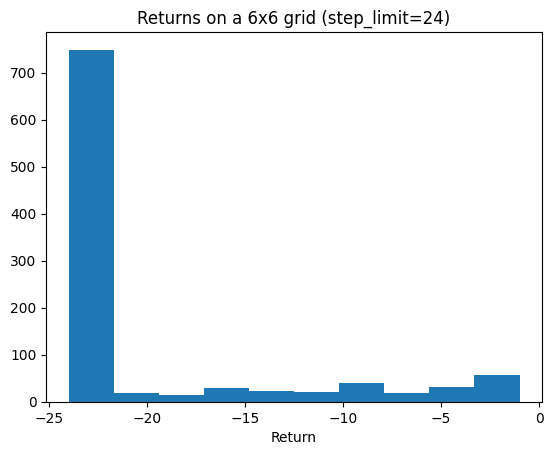

In [13]:
keys = jax.random.split(jax.random.PRNGKey(0), 1000)
returns = jnp.array([random_rollout(key) for key in keys])
print(f"Average return: {returns.mean():.1f} +/- {returns.std():.1f}")
plt.hist(returns)
plt.title("Returns on a 6x6 grid (step_limit=24)")
plt.xlabel("Return");

## Training (optional)

In [14]:
from tqdm.auto import trange

In [15]:
def make_policy_network(epsilon: float, eval_epsilon: float):
    def q_network_fn(observation: Observation) -> chex.Array:
        x = jnp.stack(
            [
                observation.agent_location.x,
                observation.agent_location.y,
                observation.target_location.x,
                observation.target_location.y,
                observation.step_count,
            ],
            axis=-1,
            dtype=jnp.float32,
        )
        return hk.nets.MLP([32, 32, 5])(x)

    q_network = hk.without_apply_rng(hk.transform(q_network_fn))

    def policy_fn(
            params: hk.Params,
            observation: Observation,
            key: chex.PRNGKey,
            epsilon: float,
    ) -> Tuple[chex.Numeric, chex.Array]:
        q_values = q_network.apply(params, observation)
        q_values = jnp.where(observation.action_mask, q_values, jnp.finfo("float32").min)
        dist = distrax.EpsilonGreedy(q_values, epsilon)
        action = dist.sample(seed=key)
        return action, q_values

    policy = functools.partial(policy_fn, epsilon=epsilon)
    eval_policy = functools.partial(policy_fn, epsilon=eval_epsilon)
    return policy, eval_policy, q_network

In [16]:
gamma = 0.95
epsilon = 0.2
batch_size = 64
seed = 0
num_updates_per_epoch = 50
eval_batch_size = 10
num_epochs = 100

grid_world = GridWorld(6)
train_grid_world = VmapWrapper(AutoResetWrapper(grid_world))
eval_grid_world = grid_world

policy, eval_policy, q_network = make_policy_network(epsilon=epsilon, eval_epsilon=0.0)

In [17]:
def train_step(
        params: hk.Params,
        optimizer_state: optax.OptState,
        states: State,
        timesteps: TimeStep,
        keys: chex.PRNGKey,
):
    def loss(params: hk.Params, states: State, timesteps: TimeStep, keys: chex.PRNGKey):
        actions, q_values = jax.vmap(policy, in_axes=(None, 0, 0))(params, timesteps.observation, keys)
        selected_q_values = jnp.take_along_axis(q_values, actions[:, None], axis=-1).squeeze(axis=-1)
        states, timesteps = train_grid_world.step(states, actions)
        _, next_q_values = jax.vmap(policy, in_axes=(None, 0, 0))(params, timesteps.observation, keys)
        td_error = (
                timesteps.reward + gamma * timesteps.discount * jnp.max(next_q_values, axis=-1) - selected_q_values
        )
        return jnp.mean(td_error**2), (states, timesteps)
    (dqn_loss, (states, timesteps)), grad = jax.value_and_grad(loss, has_aux=True)(
        params, states, timesteps, keys,
    )
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    metrics = {
        "dqn_loss": dqn_loss,
        "discount": jnp.mean(timesteps.discount),
    }
    return (params, optimizer_state, states, timesteps), metrics

@jax.jit
def train_multi_step(
        params: hk.Params,
        optimizer_state: optax.OptState,
        states: State,
        timesteps: TimeStep,
        keys: chex.PRNGKey,
):
    (params, optimizer_state, states, timesteps), metrics = jax.lax.scan(
        lambda carry, k: train_step(*carry, k),
        (params, optimizer_state, states, timesteps),
        keys,
    )
    metrics = jax.tree_util.tree_map(jnp.mean, metrics)
    return (params, optimizer_state, states, timesteps), metrics

@jax.jit
def evaluate(params: hk.Params, key: chex.PRNGKey):
    def evaluate_one_episode(key: chex.PRNGKey):
        def one_step(
                state: State,
                timestep: TimeStep,
                return_: chex.Numeric,
                key: chex.PRNGKey,
        ):
            key, action_key = jax.random.split(key)
            action, _ = eval_policy(params, timestep.observation, action_key)
            state, timestep = eval_grid_world.step(state, action)
            return_ += timestep.reward
            return state, timestep, return_, key
        state, timestep = eval_grid_world.reset(key)
        *_, return_, _ = jax.lax.while_loop(
            lambda carry: ~carry[1].last(),
            lambda carry: one_step(*carry),
            (state, timestep, jnp.float32(0), key),
        )
        return return_
    keys = jax.random.split(key, eval_batch_size)
    returns = jax.vmap(evaluate_one_episode)(keys)
    return jnp.mean(returns)

In [18]:
key, params_key = jax.random.split(jax.random.PRNGKey(seed))
params = q_network.init(params_key, train_grid_world.observation_spec().generate_value())
optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(params)
states, timesteps = train_grid_world.reset(jax.random.split(key, batch_size))

returns = []
for _ in trange(num_epochs):
    key, epoch_key, eval_key = jax.random.split(key, 3)
    keys = jax.random.split(epoch_key, batch_size * num_updates_per_epoch).reshape(
        (num_updates_per_epoch, batch_size, -1)
    )
    (params, optimizer_state, states, timesteps), metrics = train_multi_step(
        params, optimizer_state, states, timesteps, keys,
    )
    returns.append(evaluate(params, eval_key))

  0%|          | 0/100 [00:00<?, ?it/s]

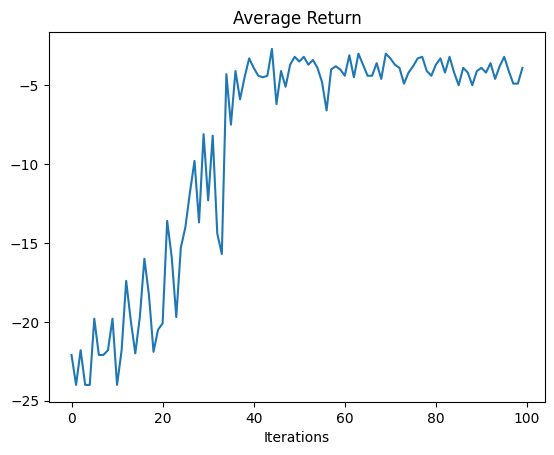

In [19]:
plt.plot(returns)
plt.title("Average Return")
plt.xlabel("Iterations");